In [1]:
!pip install pmdarima
import pandas as pd
import numpy as np
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.0 MB/s eta 0:00:00


In [2]:
file_path = '/content/Godishala Substation arima (1).xlsx'
data = pd.read_excel(file_path)

In [3]:
power_column = data['POWER (KW)']
mean_power = power_column.mean()
max_power = power_column.max()
normalized_power = power_column / max_power
print(max_power)

# Add the normalized column back to the dataframe (optional)
data['Normalized POWER (KW)'] = normalized_power
ts =normalized_power

6306.206464769449


In [4]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(ts)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# Apply differencing if necessary
if result[1] > 0.05:
    ts_diff = np.diff(ts, n=1)
else:
    ts_diff = ts

ADF Statistic: -4.551621148652979
p-value: 0.00015845647711964998


In [5]:
model = pm.auto_arima(ts, start_p=0, start_q=0, max_p=6, max_q=6,
                      seasonal=False, stepwise=True, trace=True,
                      error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-18042.825, Time=1.69 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-18160.373, Time=0.86 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-18155.329, Time=5.78 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-18044.825, Time=0.86 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-18160.216, Time=6.24 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-18160.142, Time=1.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-18159.187, Time=6.68 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-18162.373, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-18162.216, Time=1.36 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-18162.142, Time=1.58 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-18157.329, Time=0.86 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-18161.186, Time=3.26 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 30.720 seconds


In [6]:
#p, d, q = model.order
p, d, q = model.order
print(f'Optimal ARIMA parameters: p={p}, d={d}, q={q}')

arima_model = SARIMAX(ts, order=(1,1,0))
results = arima_model.fit(disp=False)

# Step 5: Generate in-sample predictions
predicted_values = results.fittedvalues

Optimal ARIMA parameters: p=1, d=1, q=0


In [7]:
print(predicted_values)

0       0.000000
1       0.311976
2       0.311976
3       0.311976
4       0.396108
          ...   
8755    0.200967
8756    0.193358
8757    0.185146
8758    0.169290
8759    0.140886
Length: 8760, dtype: float64


In [8]:
n_periods = 30  # Number of periods to forecast
forecast = results.get_forecast(steps=n_periods)
predicted_series = pd.Series(predicted_values, index=ts.index)
forecast_index = pd.date_range(start=ts.index[-1], periods=n_periods, freq='H')

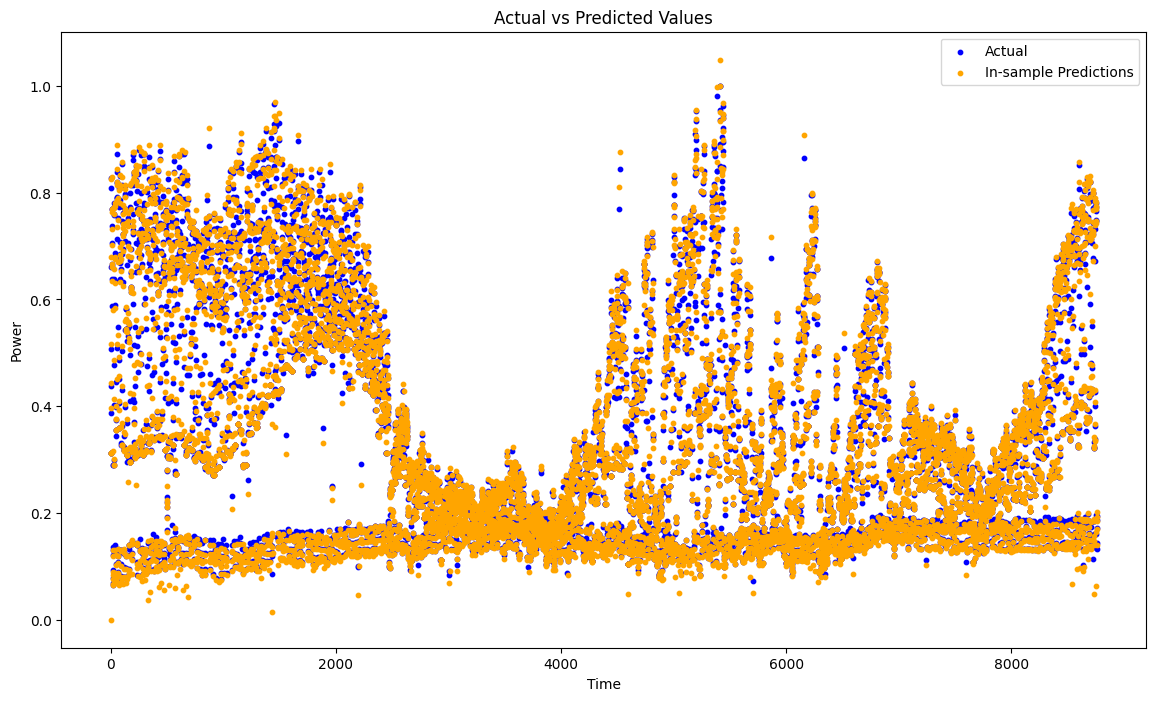

In [9]:
plt.figure(figsize=(14, 8))
plt.scatter(ts.index, ts, color='blue', label='Actual', s=10)
plt.scatter(predicted_series.index, predicted_series, color='orange', label='In-sample Predictions', s=10)
plt.legend()
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Power')
plt.show()

In [10]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt
r2 = r2_score(ts, predicted_values)
print(f'R^2: {r2}')
mse = mean_squared_error(ts, predicted_values)
print(f'Mean Squared Error (MSE): {mse}')
# Calculate MAE for in-sample predictions
mae = mean_absolute_error(ts,predicted_values)
print(f'Mean Absolute Error (MAE): {mae}')

R^2: 0.8271887081009341
Mean Squared Error (MSE): 0.00736874810996972
Mean Absolute Error (MAE): 0.04193792666377725


In [13]:
mape=np.mean(np.abs((ts - predicted_values) / ts)) * 100
print(mape)

15.897672258095
